In [1]:
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from paper_changes import *
from collections import defaultdict
from tqdm import tqdm
from scipy.stats import zscore

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
import pickle
import pandas as pd

def load_data(field='relative', zscore=True):
    infile = '/userdata/pdaly/supereeg/results/samp100_2h_54pid_pos-1.18.power.pkl'
    data = pickle.load(open(infile, 'rb'))
    labels = pd.read_csv('/home/kscangos/Sandbox/full_patient_list_pd_feb.csv', index_col=0)
    labels['pid'] = labels.index.map(lambda pid: pid[2:])
    df = data[field]
    df = df.reset_index().merge(labels[['pid', 'dep']], left_on='index',
                           right_on='pid').set_index('index').drop('pid', axis=1)
    df.rename(columns={'Dep': 'dep'}, inplace=True)
    df.drop(['92','111','119','131','135','27','115','130',
             '144','158','162','170','183'], axis=0, inplace=True)
    X, y = df.drop('dep', axis=1), df.dep
    if zscore:
        X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)
    return X, y

# Log Odds

In [4]:
X, y = load_data()

pipe = Pipeline([('pca', PCA()),
                 ('clf', LogisticRegression(C=0.75, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=['pc_' + str(i+1) for i in range(X.shape[1])])

pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 LogisticRegression(C=0.75, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

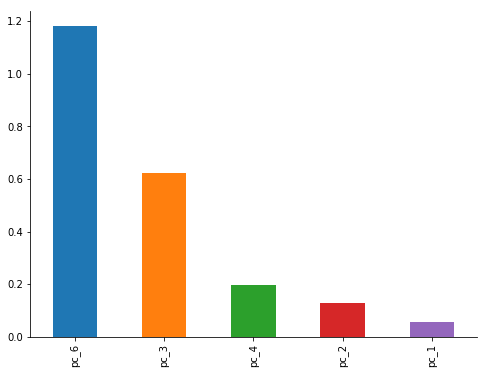

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
feats = get_feats(pipe)
feats[feats != 0].abs().sort_values(ascending=False).plot(kind='bar')
sns.despine()

plt.savefig("/home/kscangos/paper_figs/logit_coefs.pdf", transparent=True)

In [6]:
pca = pipe.named_steps['pca']
logit = pipe.named_steps['clf']

In [7]:
U = pca.components_
b = logit.coef_

U_gt2 = np.copy(U)
U_gt2[np.abs(U_gt2) <= 0.2] = 0
Uhat_gt2 = U_gt2.T.dot(b.T)
Uhat = U.T.dot(b.T)

In [8]:
np.allclose(Uhat, Uhat_gt2)

False

In [9]:
np.allclose(X.dot(U.T).values, pd.DataFrame(pca.transform(X), index=X.index))

True

In [10]:
# log odds
P = X * Uhat.squeeze()

In [112]:
P.to_csv('../temp/P_pca_logit-norf.csv')

In [11]:
P2 = X * Uhat_gt2.squeeze()

In [114]:
P2.to_csv('../temp/P_pca_logit-norf_gt-02.csv')

# Sandbox 

In [12]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [13]:
pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=10)),
                 ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100, tol=1e-6))])
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=Xt.columns[pipe.steps[-2][1].get_support()])

Xt = pd.DataFrame(PCA().fit_transform(X), columns=['pc_' + str(i) for i in range(Xt.shape[1])])

pipe.fit(Xt, y)

NameError: name 'Xt' is not defined

In [14]:
feats = get_feats(pipe)
feats[feats != 0].abs().sort_values(ascending=False).plot(kind='bar')
sns.despine()

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [67]:
feats

pc_2     0.153522
pc_3    -0.603747
pc_4     0.235970
pc_5     0.000000
pc_6    -1.416538
pc_13    0.000000
pc_18    0.000000
pc_19    0.000000
pc_21    0.000000
pc_24    0.000000
dtype: float64

In [117]:
pipe.predict_proba(X)

array([[0.73813346, 0.26186654],
       [0.28762409, 0.71237591],
       [0.69453798, 0.30546202],
       [0.12349071, 0.87650929],
       [0.26657832, 0.73342168],
       [0.89970904, 0.10029096],
       [0.49667311, 0.50332689],
       [0.6986968 , 0.3013032 ],
       [0.22874081, 0.77125919],
       [0.18698576, 0.81301424],
       [0.83905808, 0.16094192],
       [0.38976239, 0.61023761],
       [0.15727986, 0.84272014],
       [0.27950648, 0.72049352],
       [0.34388628, 0.65611372],
       [0.59492937, 0.40507063],
       [0.12543549, 0.87456451],
       [0.09497121, 0.90502879],
       [0.67834406, 0.32165594],
       [0.74768629, 0.25231371],
       [0.75300324, 0.24699676],
       [0.93479437, 0.06520563],
       [0.38498286, 0.61501714],
       [0.58386292, 0.41613708],
       [0.36863347, 0.63136653],
       [0.92784791, 0.07215209],
       [0.08212525, 0.91787475],
       [0.19239465, 0.80760535],
       [0.7039574 , 0.2960426 ],
       [0.71758738, 0.28241262],
       [0.

In [127]:
probas = pd.DataFrame(
    pipe.predict_proba(X)[:, 1],
    index = X.index,
    columns=['proba']
)
probas['actual'] = y
probas['pred'] = pipe.predict(X)
probas['match'] = probas['actual'] == probas['pred']
probas.sort_values('proba', inplace=True)

In [129]:
probas.match.value_counts(normalize=True)

True     0.804878
False    0.195122
Name: match, dtype: float64

In [130]:
probas.to_csv('../temp/preds_pca-logit.csv')

In [15]:
pcs = pd.DataFrame(
    U_gt2.T,
    columns=['pc_' + str(i) for i in range(U.shape[1])],
    index=X.columns
)

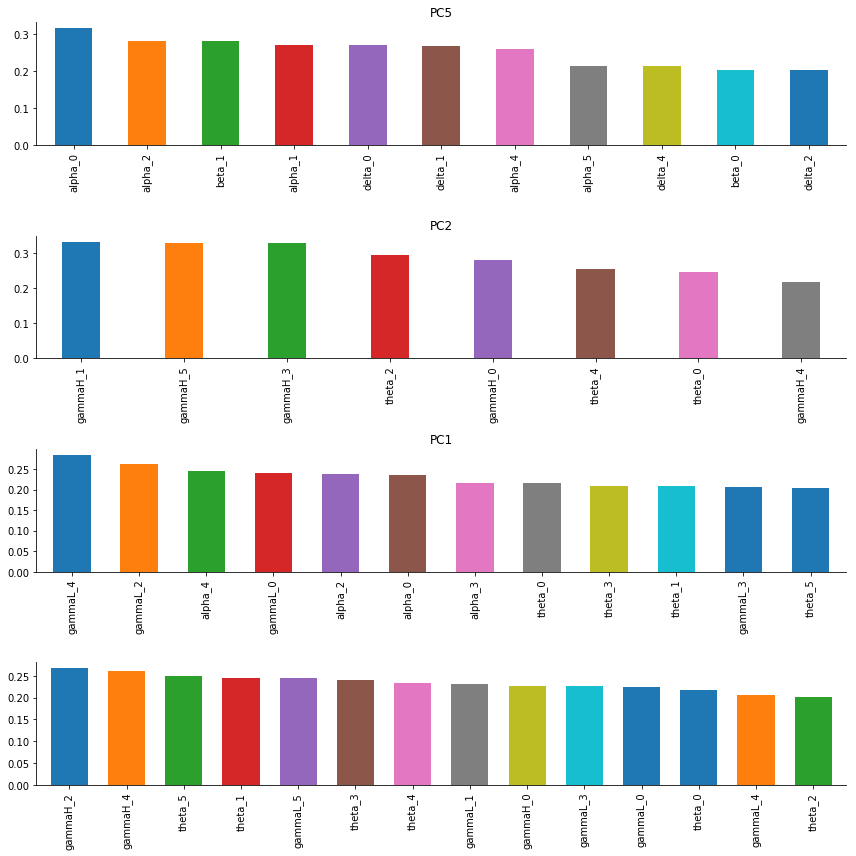

In [16]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12))

pc5 = pcs['pc_5'].abs().sort_values(ascending=False)
pc5 = pc5[pc5 > 0.2]
pc2 = pcs['pc_2'].abs().sort_values(ascending=False)
pc2 = pc2[pc2 > 0.2]
pc3 = pcs['pc_3'].abs().sort_values(ascending=False)
pc3 = pc3[pc3 > 0.2]
pc1 = pcs['pc_1'].abs().sort_values(ascending=False)
pc1 = pc1[pc1 > 0.2]

width = 0.65
max_bar = max((len(pc) for pc in (pc5, pc3, pc2, pc1)))


pc5.plot(kind='bar', ax=axs[0], width=width*len(pc5)/max_bar)
axs[0].set_title('PC5')

pc2.plot(kind='bar', ax=axs[1], width=width*len(pc2)/max_bar)
axs[1].set_title('PC2')

pc3.plot(kind='bar', ax=axs[2], width=width*len(pc3)/max_bar)
axs[2].set_title('PC3')

pc1.plot(kind='bar', ax=axs[3], width=width*len(pc1)/max_bar)
axs[2].set_title('PC1')

sns.despine()

plt.tight_layout()

plt.savefig('../temp/pcs_bar_graph.pdf', transparent=True)

In [174]:
pcs.dot(b.squeeze())

alpha_0    -0.325904
alpha_1     0.307564
alpha_2    -0.297581
alpha_3     0.030775
alpha_4     0.341649
alpha_5     0.241278
beta_0     -0.250734
beta_1      0.319354
beta_2     -0.012571
beta_3     -0.012252
beta_4     -0.012474
beta_5     -0.012690
delta_0     0.330460
delta_1    -0.301292
delta_2     0.250846
delta_3     0.013023
delta_4    -0.239676
delta_5     0.012740
gammaH_0   -0.145424
gammaH_1   -0.207273
gammaH_2    0.034752
gammaH_3   -0.204077
gammaH_4   -0.102476
gammaH_5   -0.204511
gammaL_0   -0.018078
gammaL_1    0.029944
gammaL_2   -0.051300
gammaL_3   -0.011022
gammaL_4   -0.029011
gammaL_5    0.031727
theta_0    -0.223068
theta_1    -0.072609
theta_2    -0.209000
theta_3    -0.072032
theta_4    -0.189475
theta_5    -0.072213
dtype: float64

In [17]:
tf = pcs.dot(b.squeeze()).to_frame()

In [18]:
tf['band'] = tf.reset_index()['index'].apply(lambda i: i.split('_')[0]).values
tf['cluster'] = tf.reset_index()['index'].apply(lambda i: i.split('_')[1]).values
tf.rename(columns={0: 'loading'}, inplace=True)
tf.head()

,loading,band,cluster
alpha_0,-0.325905,alpha,0
alpha_1,0.307565,alpha,1
alpha_2,-0.297581,alpha,2
alpha_3,0.030775,alpha,3
alpha_4,0.341649,alpha,4


In [265]:
order = {'delta': 0, 'theta': 1, 'alpha': 2, 'beta': 3, 'gammaL': 4, 'gammaH': 5}
tf['band_val'] = tf.band.apply(lambda b: order[b])

In [38]:
idxs = [(str(cluster), band) for cluster in range(6) for band in ['delta', 'theta', 'alpha', 'beta', 'gammaL', 'gammaH']]

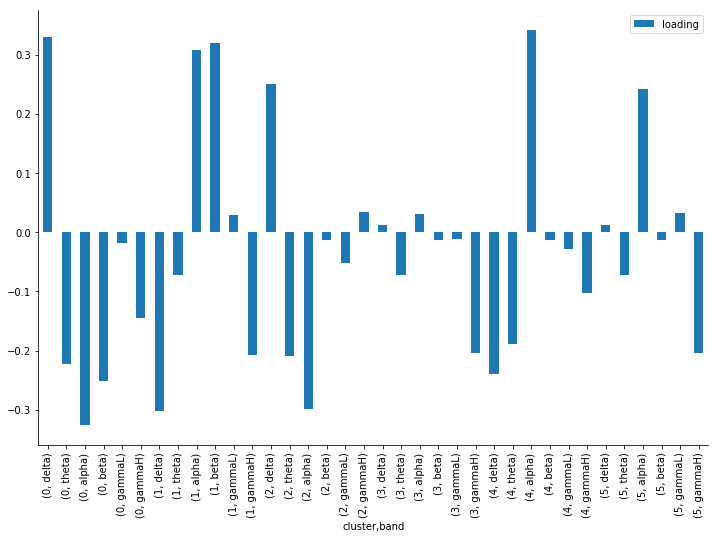

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
tf.set_index(['cluster', 'band']).reindex(pd.MultiIndex.from_tuples(idxs, names=['cluster', 'band'])) \
  .plot(kind='bar', ax=ax)

sns.despine()

plt.savefig('../temp/pca_logodds_cluster_band_barchart.pdf', transparent=True)

In [160]:
X.head() 

,alpha_0,alpha_1,alpha_2,alpha_3,alpha_4,alpha_5,beta_0,beta_1,beta_2,beta_3,...,gammaL_2,gammaL_3,gammaL_4,gammaL_5,theta_0,theta_1,theta_2,theta_3,theta_4,theta_5
index,,,,,,,,,,,,,,,,,,,,,
06,-1.171545,-1.007934,-1.427948,-1.330325,-1.254318,-1.188191,-0.667907,-0.936418,-1.214666,-0.723659,...,-0.787012,0.104539,0.054161,-0.061987,0.724667,0.381175,1.141324,0.518739,0.285597,0.305651
09,-0.803048,-0.579526,-1.595245,-0.689572,-1.078105,-0.518234,-1.212330,-1.377795,-1.673247,-1.089104,...,-1.310952,-0.312551,-1.083716,-0.544938,-0.523015,-0.564403,-0.466070,-0.627590,-0.597132,-0.799044
100,-0.766488,-0.466758,-0.944603,-1.063571,-0.982729,-0.814833,-0.612789,-0.613129,-0.964590,-1.014141,...,-0.752380,-0.890631,-0.767007,-0.627034,0.678573,1.167342,0.516342,0.433904,0.758257,1.154174
107,-0.198560,-0.071947,-0.277018,-0.209148,-0.206680,-0.263718,0.161060,0.445352,0.189879,0.055081,...,1.094925,0.734339,0.851653,1.595057,-2.558494,-2.406823,-2.794658,-2.327962,-2.614792,-2.410005
108,-1.222735,-1.300830,-1.341565,-1.464312,-1.179208,-1.132890,-1.140384,-1.396495,-1.178733,-1.276592,...,-0.569849,0.424504,-0.385783,-0.685752,-0.998003,-0.792305,-1.011361,-1.031028,-0.868542,-0.657864


In [158]:
pcs.head() 

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_26,pc_27,pc_28,pc_29,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35
alpha_0,-0.196578,-0.104400,-0.065911,0.235320,-0.231316,0.314810,0.015099,0.064669,0.220428,-0.108406,...,0.214572,0.087430,0.292125,-0.049308,4.111228e-01,0.000000,0.000000,0.000000,-0.000000,0.000000
alpha_1,-0.209418,-0.094966,-0.069408,0.175544,-0.253089,-0.270269,0.096541,0.056542,0.176276,0.096994,...,0.012308,-0.142840,-0.266525,0.046648,-1.197232e-16,-0.167167,0.163305,-0.072344,-0.292750,0.015495
alpha_2,-0.203038,-0.091099,-0.020089,0.236732,-0.120625,0.281352,-0.224569,0.208275,-0.298065,-0.114690,...,-0.187323,0.119261,-0.030333,0.033775,-2.184551e-15,0.045382,-0.040020,-0.289020,0.038005,0.280006
alpha_3,-0.203395,-0.098511,-0.078565,0.215604,-0.127938,0.183340,-0.197825,-0.241645,-0.046322,0.194894,...,-0.163322,-0.196425,-0.150487,0.001104,-8.181961e-16,-0.175289,-0.182320,0.204808,-0.040616,0.219266
alpha_4,-0.205591,-0.080751,-0.055404,0.245987,0.004079,-0.258100,-0.093060,0.029511,-0.198098,0.241913,...,0.149253,0.117061,0.119958,0.004539,2.453970e-15,0.187264,0.270190,0.187510,0.008074,0.200717


In [159]:
b

array([[ 0.05662048,  0.12993527, -0.6243805 ,  0.19615148,  0.        ,
        -1.18186391,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])